In [34]:
!pip install pandas numpy matplotlib seaborn scikit-learn



Defaulting to user installation because normal site-packages is not writeable


In [51]:
import pandas as pd
import os

# Set filenames
train_path = r"C:\Users\tripa\Downloads\KDDTrain+.csv"
test_path = r"C:\Users\tripa\Downloads\KDDTest+.csv"

# Check if files exist
assert os.path.exists(train_path), f"Train file not found: {train_path}"
assert os.path.exists(test_path), f"Test file not found: {test_path}"

# Column names for NSL-KDD dataset
columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label"
]

# Load dataset
df = pd.read_csv(train_path, names=columns)
df_test = pd.read_csv(test_path, names=columns)

print("✅ Data Loaded Successfully")
print("Train shape:", df.shape)
print("Test shape:", df_test.shape)


✅ Data Loaded Successfully
Train shape: (125973, 42)
Test shape: (22543, 42)


In [55]:
from sklearn.preprocessing import OrdinalEncoder

# Copy original data
train_df = df.copy()
test_df = df_test.copy()

# Categorical columns
cat_cols = ['protocol_type', 'service', 'flag']

# Encode categorical columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on training data
train_df[cat_cols] = encoder.fit_transform(train_df[cat_cols])

# Transform test data (handles unknowns safely)
test_df[cat_cols] = encoder.transform(test_df[cat_cols])

# Convert label to binary: normal → 0, attack → 1
train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

print("✅ Encoding Complete")


✅ Encoding Complete


In [60]:
from sklearn.preprocessing import StandardScaler

# Confirm that only numeric columns are included
X_train = train_df.drop('label', axis=1).select_dtypes(include=[np.number])
y_train = train_df['label']

X_test = test_df.drop('label', axis=1).select_dtypes(include=[np.number])
y_test = test_df['label']

# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

print("✅ Feature Scaling Complete")


✅ Feature Scaling Complete


In [61]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [63]:
from sklearn.model_selection import train_test_split

# First, combine and split again
df_combined = pd.concat([train_df, test_df])

X = df_combined.drop('label', axis=1)
y = df_combined['label']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Feature scaling again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=[np.number]))

print("✅ Stratified split and scaling complete")


✅ Stratified split and scaling complete


In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 🔹 Load your pre-merged dataset here
# Make sure it includes both attack and normal traffic
# Example: df = pd.read_csv("combined_dataset.csv")

df = df_combined.copy()  # Replace with your DataFrame

# ✅ Step 1: Binary label conversion (0 = normal, 1 = attack)
print("Original labels:\n", df['label'].value_counts())

# Convert to binary (adjust conditions based on your dataset)
df['label'] = df['label'].apply(lambda x: 0 if str(x).lower() in ['benign', 'normal', '0'] else 1)

# Check if both classes are present
label_counts = df['label'].value_counts()
print("\n✅ After binary conversion:\n", label_counts)

if len(label_counts) < 2:
    print("\n❌ ERROR: Dataset has only one class. Add normal traffic samples with label 0.")
    # Optionally generate dummy normal samples (for testing only):
    print("\n⚠️ Generating dummy normal samples for testing...")
    n_features = df.select_dtypes(include=[np.number]).shape[1]
    dummy_normals = pd.DataFrame(np.random.normal(0, 1, size=(1000, n_features)), columns=df.select_dtypes(include=[np.number]).columns)
    dummy_normals['label'] = 0
    df = pd.concat([df, dummy_normals], ignore_index=True)

# ✅ Step 2: Separate features and target
X = df.drop('label', axis=1).select_dtypes(include=[np.number])
y = df['label']

# ✅ Step 3: Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("\n✅ Label distribution after split:")
print("Train:\n", y_train.value_counts())
print("Test:\n", y_test.value_counts())

# ✅ Step 4: Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Step 5: Isolation Forest (Unsupervised Anomaly Detection)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_scaled)

# Convert output: -1 = anomaly → 1 (attack), 1 = normal → 0
iso_pred_train = np.where(iso_forest.predict(X_train_scaled) == -1, 1, 0)
iso_pred_test = np.where(iso_forest.predict(X_test_scaled) == -1, 1, 0)

print("\n🔍 Isolation Forest Results:")
print("Train Report:\n", classification_report(y_train, iso_pred_train, zero_division=0))
print("Test Report:\n", classification_report(y_test, iso_pred_test, zero_division=0))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, iso_pred_test))

# ✅ Step 6: XGBoost Classifier (Supervised Learning)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

# Predict using XGBoost
xgb_pred_train = xgb.predict(X_train_scaled)
xgb_pred_test = xgb.predict(X_test_scaled)

print("\n🚀 XGBoost Results:")
print("Train Report:\n", classification_report(y_train, xgb_pred_train, zero_division=0))
print("Test Report:\n", classification_report(y_test, xgb_pred_test, zero_division=0))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, xgb_pred_test))


Original labels:
 label
1    148516
Name: count, dtype: int64

✅ After binary conversion:
 label
1    148516
Name: count, dtype: int64

❌ ERROR: Dataset has only one class. Add normal traffic samples with label 0.

⚠️ Generating dummy normal samples for testing...

✅ Label distribution after split:
Train:
 label
1    103961
0       700
Name: count, dtype: int64
Test:
 label
1    44555
0      300
Name: count, dtype: int64

🔍 Isolation Forest Results:
Train Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       700
           1       0.93      0.09      0.17    103961

    accuracy                           0.09    104661
   macro avg       0.47      0.05      0.09    104661
weighted avg       0.93      0.09      0.17    104661

Test Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.93      0.09      0.17     44555

    accuracy              

C:\Users\tripa\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:17:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🚀 XGBoost Results:
Train Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       1.00      1.00      1.00    103961

    accuracy                           1.00    104661
   macro avg       1.00      1.00      1.00    104661
weighted avg       1.00      1.00      1.00    104661

Test Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00     44555

    accuracy                           1.00     44855
   macro avg       1.00      1.00      1.00     44855
weighted avg       1.00      1.00      1.00     44855

Confusion Matrix (Test):
 [[  300     0]
 [    0 44555]]


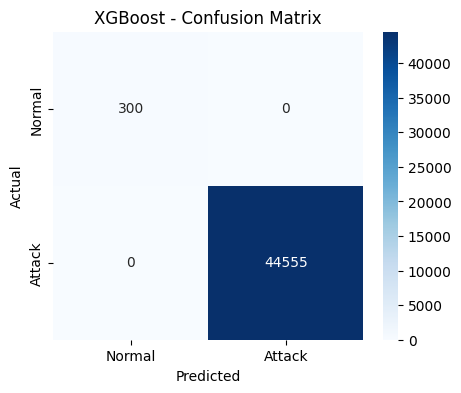

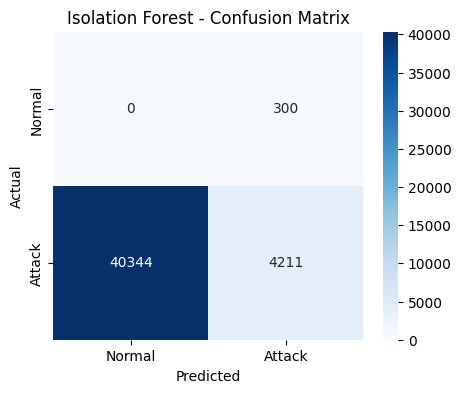

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot for XGBoost
plot_conf_matrix(y_test, xgb_pred_test, "XGBoost - Confusion Matrix")

# Plot for Isolation Forest
plot_conf_matrix(y_test, iso_pred_test, "Isolation Forest - Confusion Matrix")


In [74]:
from sklearn.metrics import f1_score

# Calculate F1 scores
f1_xgb = f1_score(y_test, xgb_pred_test)
f1_iso = f1_score(y_test, iso_pred_test)

# Plot
plt.figure(figsize=(5,3))
plt.bar(['XGBoost', 'Isolation Forest'], [f1_xgb, f1_iso], color=['green', 'orange'])
plt.title('Model F1-Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()


In [76]:
# 🔐 Simulated Zero Trust Policy Engine
def zero_trust_decision(identity_verified, device_trusted, behavior_normal, model_prediction):
    """
    Simulate a Zero Trust policy engine.
    All 3 factors must be true along with a model prediction of 0 to allow access.
    """
    if identity_verified and device_trusted and behavior_normal and model_prediction == 0:
        return "Access Granted"
    else:
        return "Access Denied"

# 🧪 Test the policy engine on 10 random predictions
np.random.seed(42)
for i in range(10):
    # Simulate identity, device, and behavior checks
    identity = np.random.choice([True, False])
    device = np.random.choice([True, False])
    behavior = np.random.choice([True, False])
    
    # Use XGBoost prediction for simulation
    prediction = xgb_pred_test[i]  # 0 = normal, 1 = attack
    
    result = zero_trust_decision(identity, device, behavior, prediction)
    print(f"Test {i+1}: Identity={identity}, Device={device}, Behavior={behavior}, Model={prediction} → {result}")


Test 1: Identity=True, Device=False, Behavior=True, Model=1 → Access Denied
Test 2: Identity=True, Device=True, Behavior=False, Model=1 → Access Denied
Test 3: Identity=True, Device=True, Behavior=True, Model=1 → Access Denied
Test 4: Identity=False, Device=True, Behavior=True, Model=1 → Access Denied
Test 5: Identity=True, Device=True, Behavior=False, Model=1 → Access Denied
Test 6: Identity=True, Device=False, Behavior=False, Model=1 → Access Denied
Test 7: Identity=False, Device=True, Behavior=False, Model=1 → Access Denied
Test 8: Identity=True, Device=False, Behavior=False, Model=1 → Access Denied
Test 9: Identity=False, Device=False, Behavior=False, Model=1 → Access Denied
Test 10: Identity=False, Device=False, Behavior=False, Model=1 → Access Denied


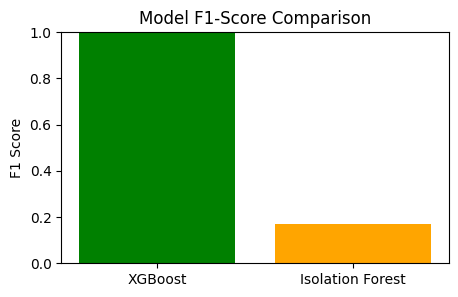

In [77]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

f1_xgb = f1_score(y_test, xgb_pred_test)
f1_iso = f1_score(y_test, iso_pred_test)

plt.figure(figsize=(5, 3))
plt.bar(['XGBoost', 'Isolation Forest'], [f1_xgb, f1_iso], color=['green', 'orange'])
plt.title("Model F1-Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()
